## Юнит 5. Компьютер говорит нет

In [1]:
import pandas as pd
from datetime import datetime

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn import preprocessing

from pandas import Series
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

## Получение данных, их анализ

In [2]:
# получение данных
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

In [3]:
data_train.shape

(73799, 19)

In [4]:
data_test.shape

(36349, 18)

In [5]:
sample.shape

(36349, 2)

In [6]:
data_train['sample'] = 1  # помечаем где у нас трейн
data_test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения Default, чтобы не путать с 1 и 0 поставим -1
data_test['default'] = -1

df = data_test.append(data_train, sort=False).reset_index(
    drop=True)  # объединяем

In [7]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,-1
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,-1
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,-1
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,-1
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,-1


In [8]:
df.shape

(110148, 20)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

## Предобработка данных

In [10]:
df.isnull().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

In [11]:
# рассмотрим поле education, чтобы заполнить пробелы
df.education.value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

In [12]:
# заполняем пустоты в education большинством - SCH
df.education = df.education.fillna('SCH')

In [13]:
# преобразуем поле дат в числовое значение - число дней от сегодняшнего дня
df.app_date = pd.to_datetime(df.app_date)
current_day = df.app_date.max()
df['days'] = (current_day - df.app_date).dt.days
type(df.loc[0,'days'])

numpy.int64

In [14]:
# обозначение для себя полей количественных и категориальных или биноминальных
col_bin = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
col_num = ['days','age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']
col_cat = ['education', 'home_address', 'work_address', 'sna', 'first_time',
    'region_rating']

## Изучение и преобразование численных переменных

<AxesSubplot:xlabel='score_bki', ylabel='Count'>

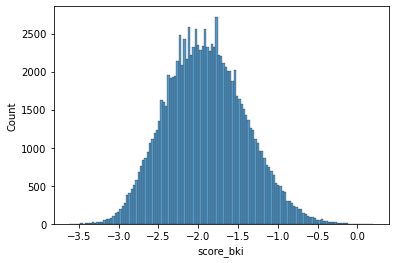

In [15]:
# рассмотрим распределение по полю score_bki
sns.histplot(df.score_bki)

распределение - нормальное

<AxesSubplot:xlabel='age', ylabel='Count'>

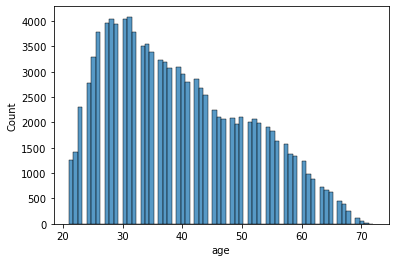

In [16]:
# рассмотрим распределение по полю age
sns.histplot(df.age)

<AxesSubplot:xlabel='decline_app_cnt', ylabel='Count'>

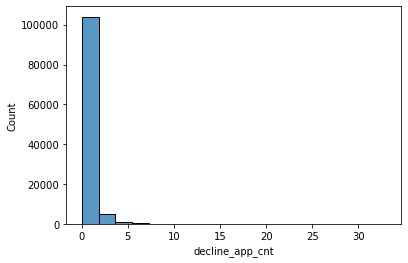

In [17]:
# рассмотрим распределение по полю age
sns.histplot(df.decline_app_cnt)

<AxesSubplot:xlabel='bki_request_cnt', ylabel='Count'>

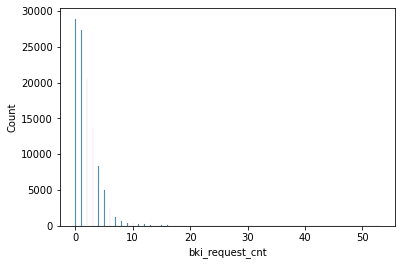

In [18]:
sns.histplot(df.bki_request_cnt)

<AxesSubplot:xlabel='days', ylabel='Count'>

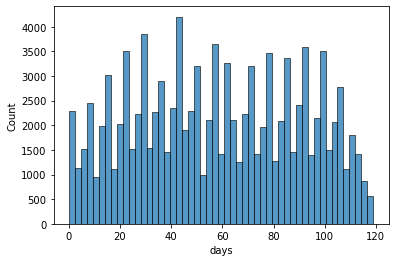

In [19]:
sns.histplot(df.days)

<AxesSubplot:xlabel='income', ylabel='Count'>

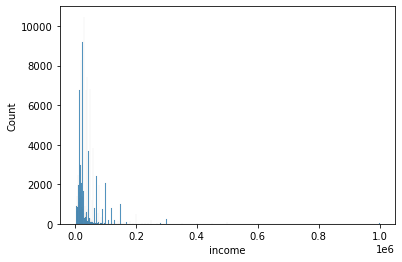

In [20]:
sns.histplot(df.income)

In [21]:
df.loc[:,'pr1']=df.loc[:,'age']*(df.loc[:,'score_bki']+5)*df.loc[:,'income']
df.loc[:,'pr2']=df.loc[:,'days']*(df.loc[:,'score_bki'])*df.loc[:,'first_time']

<AxesSubplot:xlabel='pr1', ylabel='Count'>

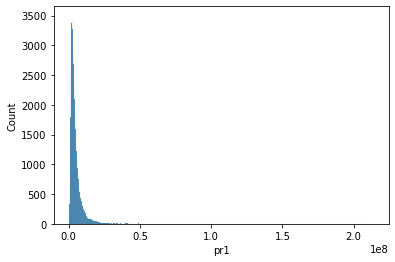

In [22]:
sns.histplot(df.pr1)

<AxesSubplot:xlabel='pr2', ylabel='Count'>

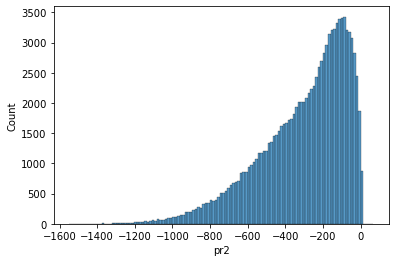

In [23]:
sns.histplot(df.pr2)

In [24]:
df.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,sample,default,days,pr1,pr2
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,1.101480e+05,110148.000000
mean,55074.500000,39.249410,0.273205,0.165514,-1.904535,2.005002,56.751189,1.574945,2.497867,41012.648537,1.731588,2.765570,0.669999,-0.244916,58.028534,4.919718e+06,-303.826802
std,31797.133063,11.518063,0.799099,0.371645,0.499397,2.266926,13.065923,0.527562,0.687651,45399.735051,1.122652,1.010151,0.470215,0.595908,32.076078,6.208123e+06,232.347142
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000,-1.000000,0.000000,6.866602e+04,-1549.978371
25%,27537.750000,30.000000,0.000000,0.000000,-2.260434,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000,-1.000000,30.000000,2.194018e+06,-441.731510
50%,55074.500000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,1.000000,0.000000,57.000000,3.429216e+06,-246.771518
75%,82611.250000,48.000000,0.000000,0.000000,-1.567888,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,1.000000,0.000000,86.000000,5.538766e+06,-119.920777
max,110148.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000,1.000000,119.000000,2.138392e+08,66.551486


<AxesSubplot:xlabel='pr1', ylabel='Count'>

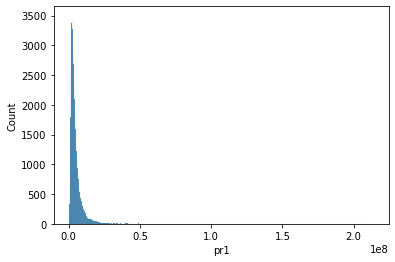

In [25]:
sns.histplot(df.pr1)

<AxesSubplot:xlabel='pr2', ylabel='Count'>

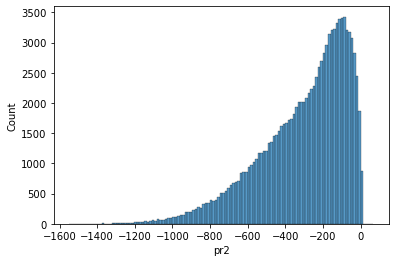

In [26]:
sns.histplot(df.pr2)

In [27]:
col_num = ['days', 'age', 'decline_app_cnt', 'score_bki',
           'bki_request_cnt', 'income', 'pr1', 'pr2']

In [28]:
df[col_num].corr()

,days,age,decline_app_cnt,score_bki,bki_request_cnt,income,pr1,pr2
days,1.000000,-0.015831,0.021489,0.061969,0.027610,0.002364,0.007423,-0.711625
age,-0.015831,1.000000,-0.111454,-0.104682,0.046975,-0.018664,0.170949,-0.061503
decline_app_cnt,0.021489,-0.111454,1.000000,0.187869,0.159927,-0.022241,-0.016265,0.082089
score_bki,0.061969,-0.104682,0.187869,1.000000,0.157451,-0.011721,0.104750,0.336316
bki_request_cnt,0.027610,0.046975,0.159927,0.157451,1.000000,0.080475,0.119443,0.032032
income,0.002364,-0.018664,-0.022241,-0.011721,0.080475,1.000000,0.933441,-0.060413
pr1,0.007423,0.170949,-0.016265,0.104750,0.119443,0.933441,1.000000,-0.020474
pr2,-0.711625,-0.061503,0.082089,0.336316,0.032032,-0.060413,-0.020474,1.000000


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='income'>

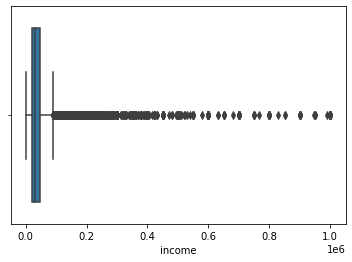

In [29]:
# рассмотрим поле income
sns.boxplot(df.income)

In [30]:
df.corr()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,sample,default,days,pr1,pr2
client_id,1.000000,0.015535,-0.021508,0.003447,-0.061653,-0.027428,0.005720,0.163686,0.163422,-0.002069,-0.001624,0.016865,0.002844,-0.012182,-0.999581,-0.007172,0.711036
age,0.015535,1.000000,-0.111454,-0.072233,-0.104682,0.046975,-0.089147,0.012135,-0.004509,-0.018664,-0.058364,0.078644,0.003864,-0.005927,-0.015831,0.170949,-0.061503
decline_app_cnt,-0.021508,-0.111454,1.000000,-0.029525,0.187869,0.159927,-0.038254,0.011095,0.015410,-0.022241,0.062434,-0.070939,0.004536,0.046868,0.021489,-0.016265,0.082089
good_work,0.003447,-0.072233,-0.029525,1.000000,0.005063,0.007789,0.070839,-0.008650,-0.011993,0.026447,-0.052889,0.058787,-0.002376,-0.018322,-0.003295,0.005927,-0.025752
score_bki,-0.061653,-0.104682,0.187869,0.005063,1.000000,0.157451,0.007132,0.016056,0.016683,-0.011721,0.067646,-0.069805,-0.000538,0.065020,0.061969,0.104750,0.336316
bki_request_cnt,-0.027428,0.046975,0.159927,0.007789,0.157451,1.000000,0.006780,0.005331,0.001763,0.080475,0.004577,0.012247,-0.002931,0.026492,0.027610,0.119443,0.032032
region_rating,0.005720,-0.089147,-0.038254,0.070839,0.007132,0.006780,1.000000,0.232971,0.254062,0.207494,-0.080876,0.090701,-0.002780,-0.035777,-0.004645,0.160821,-0.041471
home_address,0.163686,0.012135,0.011095,-0.008650,0.016056,0.005331,0.232971,1.000000,0.726535,0.037882,0.114541,-0.058430,0.001525,0.033045,-0.162314,0.030185,0.160486
work_address,0.163422,-0.004509,0.015410,-0.011993,0.016683,0.001763,0.254062,0.726535,1.000000,0.052153,0.111162,-0.062266,-0.003287,0.027715,-0.161763,0.038479,0.161717
income,-0.002069,-0.018664,-0.022241,0.026447,-0.011721,0.080475,0.207494,0.037882,0.052153,1.000000,-0.090882,0.109453,0.002735,-0.012701,0.002364,0.933441,-0.060413


<AxesSubplot:>

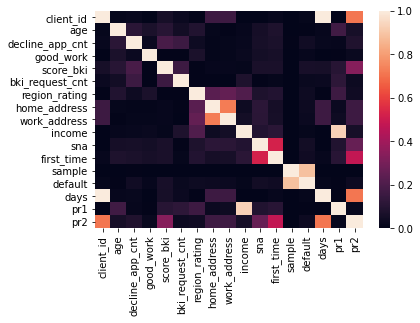

In [31]:
sns.heatmap(df.corr().abs(), vmin=0, vmax=1)

In [32]:
# убираем отработанный в числовой формат столбец
df=df.drop('app_date', axis = 1)

### Пролагорифмируем численные данные

In [33]:
col_num

['days',
 'age',
 'decline_app_cnt',
 'score_bki',
 'bki_request_cnt',
 'income',
 'pr1',
 'pr2']

In [34]:
# преобразуем переменные, в которых плохое распределение, чтобы сгладить
num_cols_log = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income','days','pr1']

for i in num_cols_log:
    df[i] = np.log(df[i] + 1)

In [35]:
df[['days',
 'age',
 'decline_app_cnt',
 'score_bki',
 'bki_request_cnt',
 'income',
 'pr1',
 'pr2']].describe()

,days,age,decline_app_cnt,score_bki,bki_request_cnt,income,pr1,pr2
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000
mean,3.831093,3.654546,0.151330,-1.904535,0.878752,10.345792,15.089677,-303.826802
std,0.855971,0.285054,0.361331,0.499397,0.658667,0.696636,0.741672,232.347142
min,0.000000,3.091042,0.000000,-3.624586,0.000000,6.908755,11.137024,-1549.978371
25%,3.433987,3.433987,0.000000,-2.260434,0.000000,9.903538,14.601245,-441.731510
50%,4.060443,3.637586,0.000000,-1.920823,0.693147,10.308986,15.047842,-246.771518
75%,4.465908,3.891820,0.000000,-1.567888,1.386294,10.778977,15.527283,-119.920777
max,4.787492,4.290459,3.526361,0.199773,3.988984,13.815512,19.180735,66.551486


### Разделение на две выборки и дальнейшие преобразования

In [36]:
df_train=df[df['sample']==1]
df_test=df[df['sample']==0]
Y_train=df_train.default
df_test=df_test.drop('default', axis=1)

In [37]:
df_train.shape

(73799, 22)

In [38]:
df_train.shape

(73799, 22)

In [39]:
poly = PolynomialFeatures(2)
x_p = poly.fit_transform(df_train[col_num].values)
X_num = StandardScaler().fit_transform(x_p)
x_p_test = poly.fit_transform(df_test[col_num].values) 
X_num_test = StandardScaler().fit_transform(x_p_test)

In [40]:
X_num.shape

(73799, 45)

In [41]:
X_num_test.shape

(36349, 45)

### Значимость непрерывных переменных

Text(0.5, 0, 'F-value')

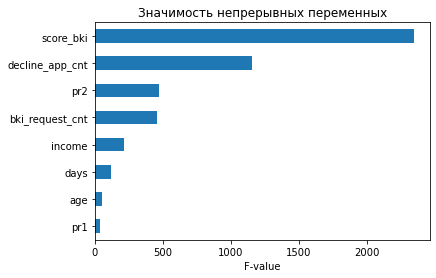

In [42]:
imp_num = Series(f_classif(df_train[col_num], df_train['default'])[0],
                 index=col_num)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')
plt.title('Значимость непрерывных переменных')
plt.xlabel('F-value')

## Преобразование категориальных признаков 

In [43]:
# разбивка категориальных признаков
df_train=pd.get_dummies(df_train, columns=['education'])
df_train=pd.get_dummies(df_train, columns=['region_rating'])
df_test=pd.get_dummies(df_test, columns=['education'])
df_test=pd.get_dummies(df_test, columns=['region_rating'])


In [44]:
col_cat

['education',
 'home_address',
 'work_address',
 'sna',
 'first_time',
 'region_rating']

In [45]:
df_train.loc[:,'adress1']=df_train.loc[:,'home_address']*df_train.loc[:,'work_address']*df_train.loc[:,'sna']
df_train.loc[:,'adress2']=(df_train.loc[:,'home_address']+df_train.loc[:,'work_address'])

In [46]:
df_test.loc[:,'adress1']=df_test.loc[:,'home_address']*df_test.loc[:,'work_address']*df_test.loc[:,'sna']
df_test.loc[:,'adress2']=(df_test.loc[:,'home_address']+df_test.loc[:,'work_address'])

In [47]:
df_train.columns

Index(['client_id', 'sex', 'age', 'car', 'car_type', 'decline_app_cnt',
       'good_work', 'score_bki', 'bki_request_cnt', 'home_address',
       'work_address', 'income', 'sna', 'first_time', 'foreign_passport',
       'sample', 'default', 'days', 'pr1', 'pr2', 'education_ACD',
       'education_GRD', 'education_PGR', 'education_SCH', 'education_UGR',
       'region_rating_20', 'region_rating_30', 'region_rating_40',
       'region_rating_50', 'region_rating_60', 'region_rating_70',
       'region_rating_80', 'adress1', 'adress2'],
      dtype='object')

In [48]:
col_cat = ['home_address', 'work_address', 'sna', 'education_ACD',
           'education_ACD', 'education_GRD', 'education_PGR', 'education_SCH', 'education_UGR',
           'region_rating_20', 'region_rating_30', 'region_rating_40',
       'region_rating_50', 'region_rating_60', 'region_rating_70',
       'region_rating_80', 'adress1', 'adress2']

In [49]:
X_cat = OneHotEncoder(sparse=False).fit_transform(df_train[col_cat].values)
X_cat_test = OneHotEncoder(sparse=False).fit_transform(df_test[col_cat].values)

In [50]:
X_cat.shape

(73799, 54)

In [51]:
X_cat_test.shape

(36349, 54)

### Значимость категориальных переменных 

Text(0.5, 1.0, 'Significance of cat variables')

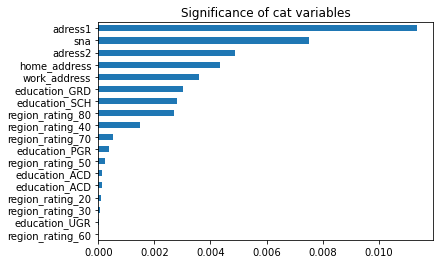

In [52]:
imp_cat = pd.Series(mutual_info_classif(df_train[col_cat],
                                        df_train['default'],
                                        discrete_features=True),
                    index=df_train[col_cat].columns)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')
plt.title('Significance of cat variables')

### Значимость бинарных признаков

In [53]:
col_bin

['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [54]:
label_encoder = LabelEncoder()

for column in col_bin:
    df_train[column] = label_encoder.fit_transform(df_train[column])

for column in col_bin:
    df_test[column] = label_encoder.fit_transform(df_test[column]) 

Text(0.5, 1.0, 'Значимость бинарных переменных')

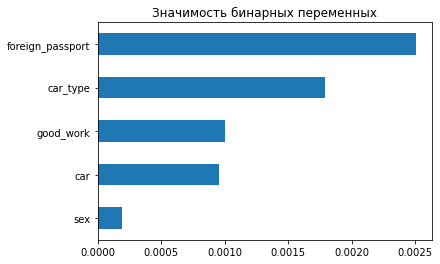

In [55]:
imp_bin = Series(mutual_info_classif(df_train[col_bin],
                                     df_train['default'],
                                     discrete_features=True),
                 index=col_bin)
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh')
plt.title('Значимость бинарных переменных')

### Данные для модели

In [56]:
# соединяем данные
X = np.hstack([X_num, df_train[col_bin], X_cat])
Y = df_train['default'].values

X1= np.hstack([X_num_test, df_test[col_bin], X_cat_test])


In [57]:
X.shape

(73799, 104)

In [58]:
Y.shape

(73799,)

In [59]:
X1.shape

(36349, 104)

## Построение модели

In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=42)

In [61]:
# построим модель с параметрами
model = LogisticRegression(penalty='l2', C=2.7825594022071245, max_iter=600)
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:, 1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Построение ROC AUC кривой

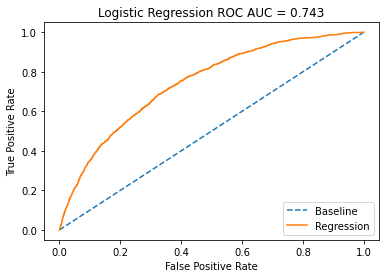

In [62]:
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Построение confusion_matrix, расчет f1_score, accuracy

In [63]:
probs

array([0.2339673 , 0.18031876, 0.06368382, ..., 0.08867865, 0.11842367,
       0.05229399])

In [64]:
# подбор границы между 0 и 1, чтобы отнести полученный default к 0 или 1,
# где значение f1 score максимальное
b = 0.17
s = 0.5-b
probs2 = probs+s

In [65]:
# превращение данных в бинарные для расчета матрицы ошибок
probs1 = np.around(probs2, decimals=0)

In [66]:
print(confusion_matrix(y_test, probs1))

[[10251  2682]
 [  861   966]]


In [67]:
f1_score(y_test, probs1)

0.3528767123287671

In [68]:
accuracy_score(y_test, probs1)

0.759959349593496

### Итоговый submission

In [69]:
probs_subm = model.predict_proba(X1)
probs_subm = probs_subm[:, 1]
probs_subm

array([0.04676825, 0.33251553, 0.06587993, ..., 0.22065312, 0.20122806,
       0.19655362])

In [70]:
sample_submission = df_test[['client_id']].copy()
sample_submission.head()

,client_id
0,74835
1,17527
2,75683
3,26883
4,28862


In [71]:
l = len(probs_subm)
for i in range(l):
    sample_submission.loc[i, 'default'] = probs_subm[i]

In [72]:
sample_submission.head()

,client_id,default
0,74835,0.046768
1,17527,0.332516
2,75683,0.065880
3,26883,0.088637
4,28862,0.026836


In [73]:
sample_submission.to_csv('sample_submission.csv', index=False)

In [74]:
sample_submission.shape

(36349, 2)